Let's start by loading the necessary libraries, and setting some configuration options for reproducibility and visualization.

In [1]:
# %%
#Import top level libraries, including the deepvelo package
import numpy as np
import scvelo as scv
import torch

from deepvelo.utils import velocity, update_dict
from deepvelo.utils.preprocess import autoset_coeff_s
from deepvelo.utils.plot import statplot, compare_plot
from deepvelo import train, Constants

# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

# set options for for visualization and verbosity
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params(
    "scvelo", transparent=False
)  # for beautified visualization

%load_ext autoreload
%autoreload 2


ImportError: cannot import name 'is_categorical' from 'pandas.api.types' (/h/hmaan/miniconda3/lib/python3.9/site-packages/pandas/api/types/__init__.py)

We're going to be using the Dentate Gyrus neurogenesis data from [La Manno et al. (2018)](https://doi.org/10.1038/s41586-018-0414-6) in this example. Start by loading and preprocessing the data.

In [2]:
adata = scv.datasets.dentategyrus_lamanno()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=30, n_pcs=30)


Filtered out 18710 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:21) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Now we're going to configure the DeepVelo model and name the experiment - we'll just call it DeepVelo for now. We're also going to empirically set the spliced correlation objective based on the data - this is recommended for best performance.

In [3]:
configs = {
    "name": "DeepVelo", # name of the experiment
    "loss": {"args": {"coeff_s": autoset_coeff_s(adata)}} # Automatic setting of the spliced correlation objective
}
configs = update_dict(Constants.default_configs, configs)


The ratio of spliced reads is 75.4% (between 70% and 85%). Suggest using coeff_s 0.75.


Now we can call the velocity and train methods to fit the model to the data. 

In [4]:
# initial velocity
velocity(adata, mask_zero=False)
trainer = train(adata, configs)

computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
building graph


INFO:train:Beginning training of DeepVelo ...


velo data shape: torch.Size([18213, 2000])


velo_mat shape: (18213, 2000)
--> added 'velocity' (adata.layers)
--> added 'velocity_unspliced' (adata.layers)
--> added 'cell_specific_beta' (adata.layers)
--> added 'cell_specific_gamma' (adata.layers)


Now that the velocity calculation is complete, we can visualize the results. We'll start by visualizing the velocity field in the embedding space.

computing velocity embedding
    finished (0:00:05) --> added
    'velocity_tsne', embedded velocity vectors (adata.obsm)


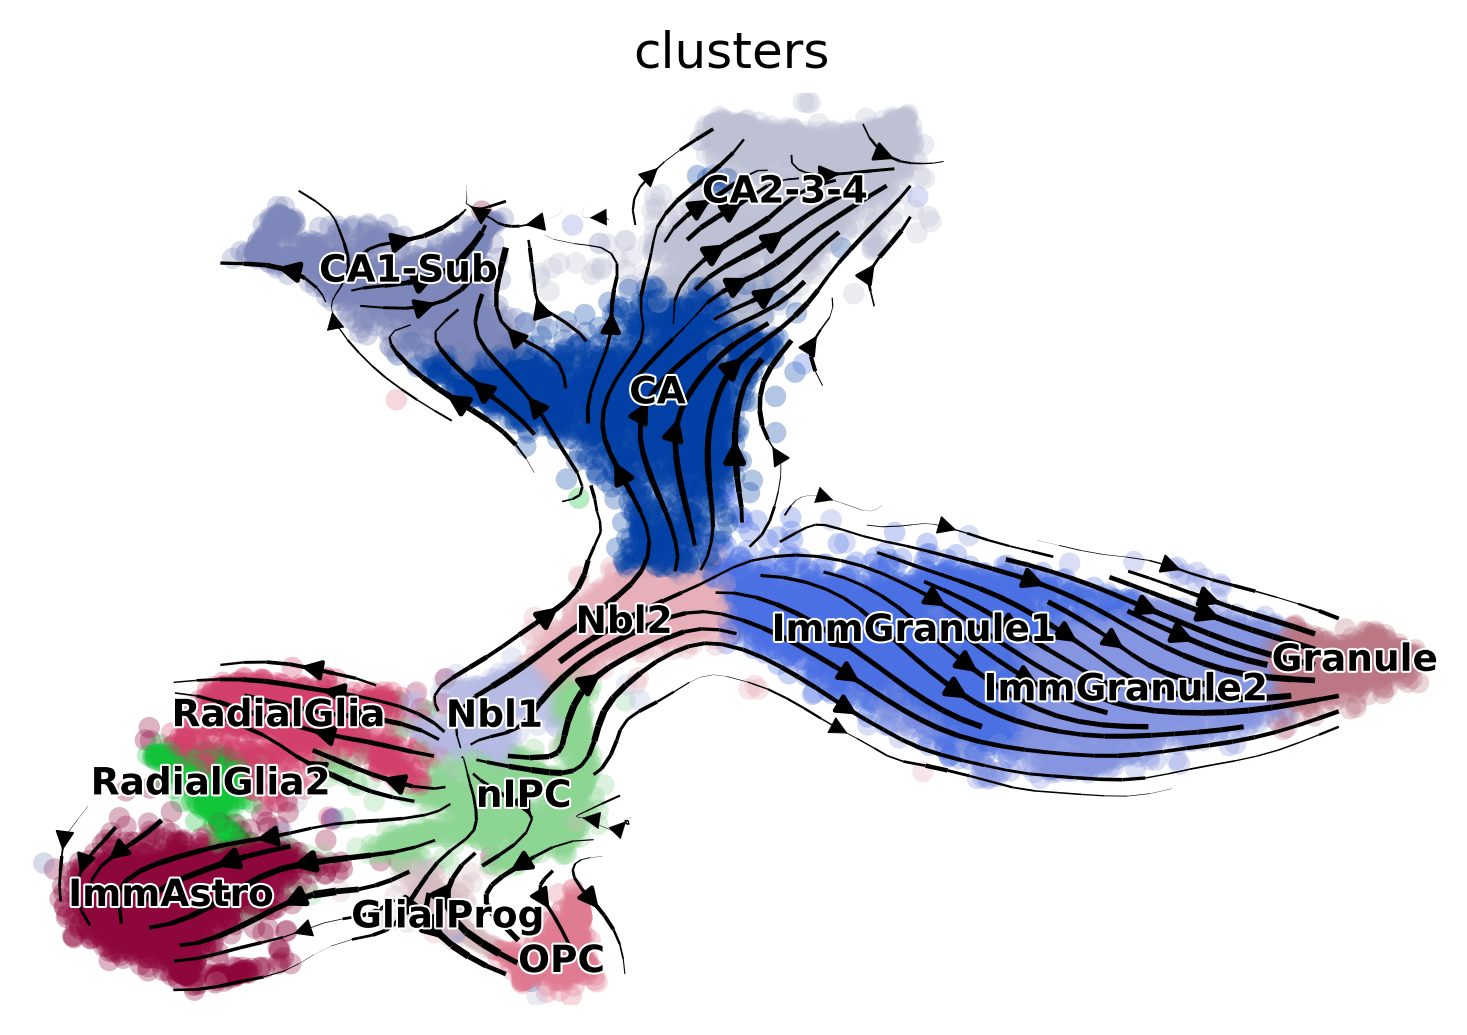

In [6]:
# velocity plot
scv.tl.velocity_graph(adata, n_jobs=8)
scv.pl.velocity_embedding_stream(
    adata,
    basis="tsne",
    color="clusters",
    legend_fontsize=9,
    dpi=150,  # increase dpi for higher resolution
)


We can further visualize the pseudotime estimated based on the velocity field, and plot this in the embedding space.

computing terminal states
    identified 3 regions of root cells and 4 regions of end points .
    finished (0:00:03) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


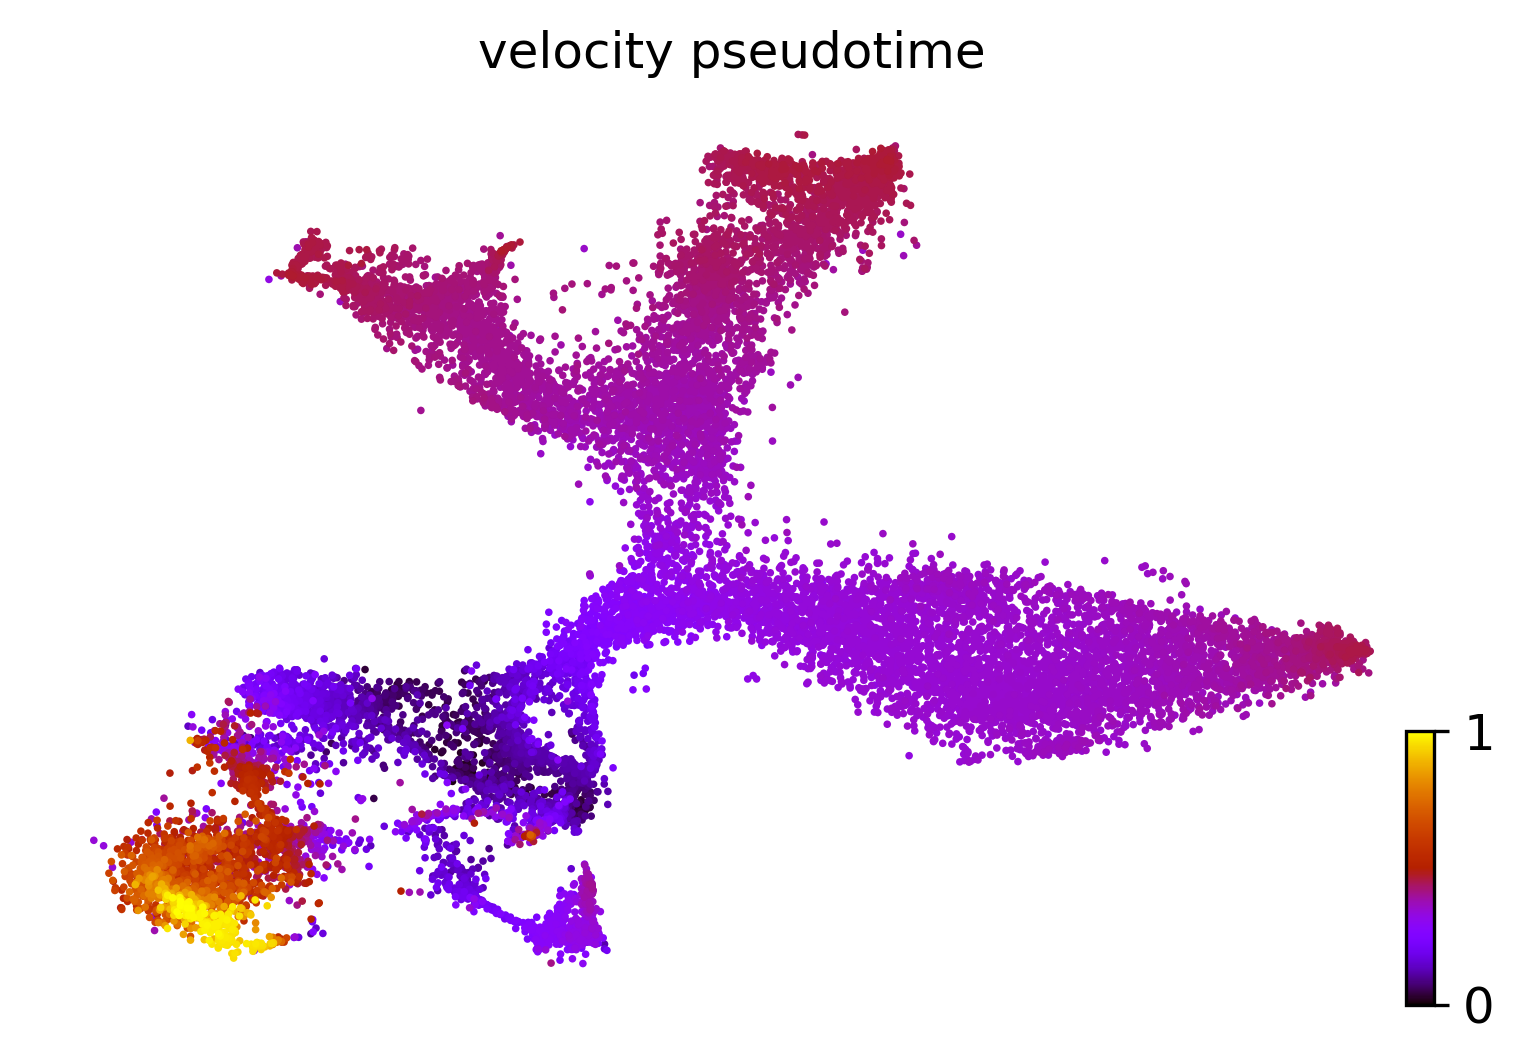

In [8]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(
    adata,
    color="velocity_pseudotime",
    cmap="gnuplot",
    dpi=150,
)

There are a number of other visualizations and analyses that can be performed - please see the rest of the examples from the paper.
